[-0.8573864070972596, -0.6433864070972598, 1.0489764220173807]
[0.09671650449143165, 0.11728349550856854, 0.6239738852284363]


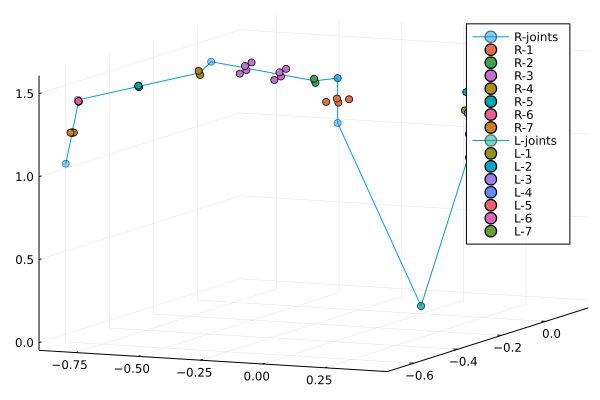

In [3]:
using CPUTime
using Plots
# using PyCall
# @pyimport matplotlib.pyplot as plt
using LinearAlgebra
using StaticArrays
using ArraysOfArrays

mutable struct DHparam
    alpha::Float64
    a::Float64
    d::Float64
    theta::Float64
end


# パラメータ
L = 278e-3
h = 64e-3
H = 1104e-3
L0 = 270.35e-3
L1 = 69e-3
L2 = 364.35e-3
L3 = 69e-3
L4 = 374.29e-3
L5 = 10e-3
L6 = 368.3e-3

q_neutral = [0; -31; 0; 43; 0; 72; 0] * pi/180  # ニュートラルの姿勢

qr = q_neutral  # 右手の関節角度ベクトル
ql = q_neutral  # 左手の関節角度ベクトル

DHparams_r = [
    DHparam(0, 0, 0, qr[1])
    DHparam(-pi/2, L1, 0, qr[2]+pi/2)
    DHparam(pi/2, 0, L2, qr[3])
    DHparam(-pi/2, L3, 0, qr[4])
    DHparam(pi/2, 0, L4, qr[5])
    DHparam(-pi/2, L5, 0, qr[6])
    DHparam(pi/2, 0, 0, qr[7])
]

DHparams_l = [
    DHparam(0, 0, 0, ql[1])
    DHparam(-pi/2, L1, 0, ql[2]+pi/2)
    DHparam(pi/2, 0, L2, ql[3])
    DHparam(-pi/2, L3, 0, ql[4])
    DHparam(pi/2, 0, L4, ql[5])
    DHparam(-pi/2, L5, 0, ql[6])
    DHparam(pi/2, 0, 0, ql[7])
]

# 制御点
c_points_1 = (
    [0; L1/2; -L0/2; 1],
    [0; -L1/2; -L0/2; 1],
    [L1/2; 0; -L0/2; 1],
    [-L1/2; 0; -L0/2; 1],
)

c_points_2 = (
    [0; 0; L3/2; 1],
    [0; 0; -L3/2; 1],
)

c_points_3 = (
    [0; L3/2; -L2*2/3; 1],
    [0; -L3/2; -L2*2/3; 1],
    [L3/2; 0; -L2*2/3; 1],
    [-L3/2; 0; -L2*2/3; 1],
    [0; L3/2; -L2*1/3; 1],
    [0; -L3/2; -L2*1/3; 1],
    [L3/2; 0; -L2*1/3; 1],
    [-L3/2; 0; -L2*1/3; 1],
)

c_points_4 = (
    [0; 0; L3/2; 1],
    [0; 0; -L3/2; 1],
)

c_points_5 = (
    [0; L5/2; -L4/2; 1],
    [0; -L5/2; -L4/2; 1],
    [L5/2; 0; -L4/2; 1],
    [-L5/2; 0; -L4/2; 1],
)

c_points_6 = (
    [0; 0; L5/2; 1],
    [0; 0; -L5/2; 1]
)

c_points_7 = (
    [0; L5/2; L6/2; 1],
    [0; -L5/2; L6/2; 1],
    [L5/2; 0; L6/2; 1],
    [-L5/2; 0; L6/2; 1],
)

c_points_GL = (
    [0; 0; L6/3; 1]
)

c_points_all = (
    c_points_1, c_points_2, c_points_3, c_points_4, c_points_5, c_points_6, c_points_7, c_points_GL
)


# 右手
T_BR_Wo = [
    -sqrt(2)/2 sqrt(2)/2 0 -L
    -sqrt(2)/2 -sqrt(2)/2 0 -h
    0 0 1 H
    0 0 0 1
]

T_0_BR = [
    1 0 0 0
    0 1 0 0
    0 0 1 L0
    0 0 0 1
]

# 左手
T_BL_Wo = [
    sqrt(2)/2 sqrt(2)/2 0 L
    -sqrt(2)/2 sqrt(2)/2 0 -h
    0 0 1 H
    0 0 0 1
]

T_0_BL = T_0_BR


T_GR_7 = [
    1 0 0 0
    0 1 0 0
    0 0 1 L6
    0 0 0 1
]

function update_DHparams(DHparams, q)
    q[2] = q[2] + pi/2
    for i in 1:7
        DHparams[i].theta = q[i]
    end
    DHparams
end

function split_vec_of_arrays(u)
    vec.(u) |>
    x -> VectorOfSimilarVectors(x).data |>
    transpose |>
    VectorOfSimilarVectors
end


function T(p::DHparam)
    """(i-1)T(i)"""
    [
        cos(p.theta) -sin(p.theta) 0 p.a
        sin(p.theta)*cos(p.alpha) cos(p.theta)*cos(p.alpha) -sin(p.alpha) -p.d*sin(p.alpha)
        sin(p.theta)*sin(p.alpha) cos(p.theta)*sin(p.alpha) cos(p.alpha) p.d*cos(p.alpha)
        0 0 0 1
    ]
end



function draw_arm(fig, q, DHparams, name)
    """アームをplot by Plots
    name : trueならright、falseならleft
    """
    DHparams = update_DHparams(DHparams, q)
    os = []
    Ts = []
    push!(os, [0.0, 0.0, 0.0])

    if name
        T_temp = T_BR_Wo
        push!(Ts, T_temp)
        push!(os, T_temp[1:3, 4])

        T_temp = T_temp * T_0_BR
        push!(Ts, T_temp)
        push!(os, T_temp[1:3, 4])
    else
        T_temp = T_BL_Wo
        push!(Ts, T_temp)
        push!(os, T_temp[1:3, 4])

        T_temp = T_temp * T_0_BL
        push!(Ts, T_temp)
        push!(os, T_temp[1:3, 4])
    end

    for i in 1:7
        T_temp = T_temp * T(DHparams[i])
        push!(Ts, T_temp)
        push!(os, T_temp[1:3, 4])
    end

    T_temp = T_temp * T_GR_7
    push!(Ts, T_temp)
    push!(os, T_temp[1:3, 4])
    println(T_temp[1:3, 4])

    x, y, z = split_vec_of_arrays(os)
    if name
        s = "R-"
    else
        s = "L-"
    end

    plot!(
        fig,
        x, y, z,
        aspect_ratio = 1,
        marker=:circle,
        markeralpha = 0.5,
        label = s * "joints",
        )

    cs_global_all = []
    for (i, cs_local) in enumerate(c_points_all)
        cs_global = []
        for r in cs_local
            o = Ts[i+2] * r
            push!(cs_global, o[1:3, :])
        end
        push!(cs_global_all, cs_global)
    end
    cname = (
        "1", "2", "3", "4", "5", "6", "7", "GL"
    )

    for (i, cs) in enumerate(cs_global_all)
        if i == 8
            continue
        else
            x, y, z = split_vec_of_arrays(cs)
            scatter!(
                fig, 
                x, y, z, label = s * cname[i],
                aspect_ratio = 1,
            )
        end
    end
    fig
end

### neutralを図示 ###
fig = plot(aspect_ratio = 1,)
fig = draw_arm(fig, qr, DHparams_r, true)
fig = draw_arm(fig, ql, DHparams_l, false)


┌ Info: Saved animation to 
│   fn = /home/thoth/src/manipulator_dynamics/jl/kinematics/tmp.gif
└ @ Plots /home/thoth/.julia/packages/Plots/CBYO0/src/animation.jl:114


Plots.AnimatedGif("/home/thoth/src/manipulator_dynamics/jl/kinematics/tmp.gif")
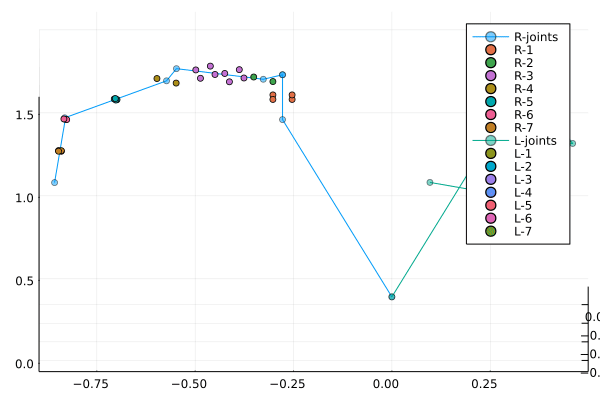

In [15]:
# 回転
@gif for i in range(0, stop = 90, length = 100)
    plot(fig, camera = (i, 30), aspect_ratio = 1,)
end

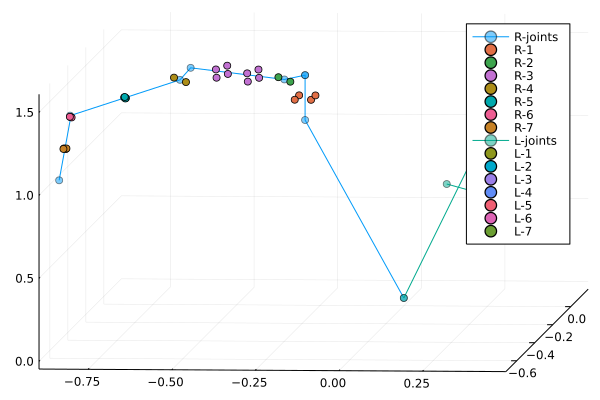

In [16]:
# 回転2
plot(fig, camera = (10, 30))

In [1]:
# スライダー
using Interact
@manipulate for i in -180:15:180
    plot!(fig, camera = (i, 0),)
end

LoadError: ArgumentError: Package Interact not found in current path:
- Run `import Pkg; Pkg.add("Interact")` to install the Interact package.
